# ML(H)
## John Williamson 2019/2020

---

# Visualisation in machine learning

## Outline
In this lab we will explore how we can use visualisation to explore data before we begin training models. We will do this in the context of a challenge to classify audio data.

### Task
The task involves optimising the pre-processing of features for a simple classification problem, using visualisation (unsupervised learning) to help guide you in choosing good feature vector selection. The idea is to get *insight* into the data **using visualisation** to create effective machine learning models.

### Classifier
We will only use the most basic of classifiers in this example -- **k nearest neighbours** -- and focus on how to process the features to make this simple algorithm work as effectively as possible. Many modern approaches would use deep learning to learn an end-to-end classifier that infers appropriate feature extraction directly.

Everything to do the analysis and testing is provided for you. Your task is to modify the parameters that affect the creation of the feature vectors (see the green highlighted box below) and explore different visualisations to help identify a good feature transform.


In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import audio_task
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Motivation
This topic is essentially the operations behind the **Stane** project [Paper](http://www.dcs.gla.ac.uk/~rod/publications/MurWilHugQua08.pdf) [Video](http://www.dcs.gla.ac.uk/~rod/Videos/i_chi2.mov)


This used 3D printed textures on mobile devices. Scratching the fingernail across the surface generates distinctive sounds, which are propagated through the case and picked up by a piezo microphone. Different regions have different textures, and thus the area being rubbed can be determined by analysing the audio signal.

<img src="imgs/piezo.png" width="400px">
<img src="imgs/stane_real.png" width="400px">
<!-- <img src="imgs/shell.png" width="400px">
<img src="imgs/disc.png" width="400px"> -->



### Feature vectors
In almost all machine learning contexts, we predict outputs given a **fixed length** set of features; the input space a fixed dimension $d$. Each of those features is usually (but not always) continuous-valued.

Sometimes the data fall naturally into this space (e.g. classifying the iris type by 3 physical measurements). In cases such as in audio classification, though, we want to make predictions based on *time series*; a set of measurements of the same variable set made repeatedly over time.

#### Windowing
One general solution to this time series problem is to break a sequence up into a fixed length sequence of previous measurements. For example the measurements $[x_{t=t}, x_{t=t-1}, x_{t=t-2}, \dots, x_{t=t-d}]$ might make up the feature vector. This process is known as *windowing*, because we chop up the data into fixed length windows by "sliding" a time window along the data. **Consecutive (but possible discontiguous or overlapping) windows are almost universally used in audio contexts.**

<img src="imgs/contiguous_windows.png">
<img src="imgs/overlapping_windows.png">

These windows can overlap, which increases the size of the training set, but excessive overlapping can capture lots of redundant features examples. This can increase overfitting and training time without improving the classifier performance. Balancing the size of the windows (and thus the feature vector size $d$) and the amount of overlap is a matter of experimentation and domain knowledge.

-----------------

## Feature transforms

Often the "natural" raw form of the data can be difficult to classify. This might be because it has very high dimension, it is very noisy, or the classification boundary just isn't very compatible with your classifier (e.g. the class borders in the original space are highly-nonlinear and you are using a linear classifier). 

**Feature engineering** is the art of finding transforms of the raw data that increase classifier performance. These can often be simple, such as dropping some of the measurements entirely (under the assumption that they are irrelvant), or averaging measurements together (under the assumption that this reduces noise).

### Audio transforms
**Audio** data tends to be very high dimensional -- you might get 4000 to 44100 measurements for a single second of data.  A single audio sample has very little information indeed; it is the longer-term (millisecond to second) properties that have all the interesting information. 

So want transforms that pull out interesting features **over time**. The classical feature transform is the **Fourier transform**, which rewrites a signal varying over time as a sum of sinusoidal (periodic) components. This functions much like our ear works, splitting up audio in **frequency bands**, each of which has a **phase** and an **amplitude**. Many of these are already implemented in standard libraries, like the Fast Fourier Transform (fft) and the Discrete Cosine Transform (dct). We will use these in our classification problem.

# The challenge
<a id="challenge"></a>
You have to use visualisation strategies to choose a feature vector transform for a classifier that classifies the region of a device that is being touched based on the sound recorded from a piezo contact microphone. There are four possible touch regions and also a silence/handling noise class (class 0):

<img src="imgs/regions.png"> 

The data are all in the `data/` folder.

You have training data for these regions, `challenge_train_{01234}.wav`

See the code below which plots test datasets consisting of labeled mixtures of these classes alongside your predicted labels.  The code below loads the data from 4Khz 16 bit mono wavefiles into a collection of features vectors `X` and a corresponding set of labels `y`.  

### Feature selection
You can modify the feature selection properties set below to adjust the results. **The rest of the pipeline is fixed  -- you cannot modify the classifier itself in this exercise.**
<div class="alert alert-box alert-success">
    
This cell below is the only control you have over the performance of the classification. You will use the visualisation techniques to explore how these transforms change the data you get. NOTE: you may well not understand the meaning of the parameters. Use the visualisations to help guide you to a good choice.
</div>

In [40]:
######### BASELINE PARAMETERS 69.xxx ##################
# You can change these values
# 1 sample = 1/4096 of a second

parameters = {
'size':256, # how long each window is, in samples
'step':128, # how many samples to move forward in each window
'decimate':1, # how much reduction of the feature vector to perform; integer = 1,2,3,4,5...
'feature_range' :(0.0, 1.0), # what slice of the feature vectors to take (0.0, 1.0)=whole vector
# must be between 0.0 and 1.0 for the start and end 
'window_fn':"boxcar", # one of window_fns (below)
'feature_fn':"raw" # one of feature_fns    
}
#####################################

# valid feature_fns: ['dct', 'fft', 'fft_phase', 'dct_phase', 'cepstrum', 'raw'])
# valid window_fns: ['hamming', 'hann', 'boxcar', 'blackmanharris']

Run the following cells to (re)load the data into a set of features and labels

In [41]:
X, y = audio_task.load_data(parameters)
print("X shape", X.shape, "y shape", y.shape)

Loading into 701 windows of length 256
Loading into 1644 windows of length 256
Loading into 1413 windows of length 256
Loading into 1999 windows of length 256
Loading into 1939 windows of length 256
Using raw transform and a boxcar window.
X shape (7696, 256) y shape (7696,)


In [42]:
# if you don't have UMAP installed, uncomment and run the line below (once only)
#!pip install --no-cache --user umap-learn

## Visualisation

We can visualise these features. Experiment with using:
* PCA `sklearn.decomposition.pca`
* LLE `sklearn.manifold.LocallyLinearEmbedding`
* ISOMAP `sklearn.manifold.Isomap`
* tSNE `sklearn.manifold.TSNE`
* UMAP `umap`

You can use alternative visualisation methods if you wish. **You may need to subsample the features to visualise in reasonable time.**. For example, you can subsample to just every 10th feature vector using `X[::10, :]`

Use the visualisations to find a feature vector selection that you expect to perform well with a a kNN classifier. Use the visualisation to explore these transforms rather than trial and error with the classifier itself.

<div class="alert alert-box alert-success"> 

**Task**: iterate over visualisations and tweaks to the feature preprocessing to see if you can find a structure that separates classes well.
</div>

# PCA

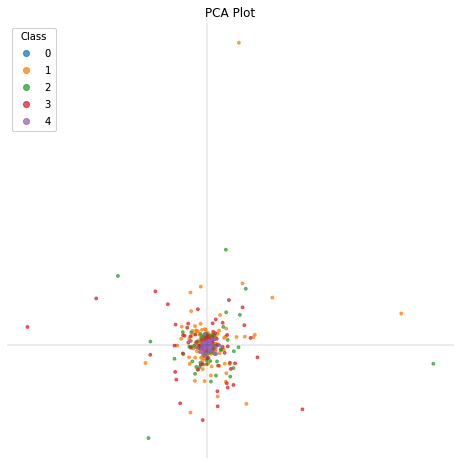

In [43]:
import sklearn.decomposition, sklearn.manifold



def visualize(vizX, vizy, subsample=subsample, heading="Visualisation plot"):
    fig, ax = plt.subplots(figsize=(8, 8))
    # show a scatter plot of the first two dimensions
    scatter = ax.scatter(
        vizX[:, 0],
        vizX[:, 1],
        c=vizy[::subsample],
        cmap="tab10",
        vmin=0,
        vmax=10,
        alpha=0.7,
        s=8,
    )


    ##### Make the figure look a bit cleaner
    # Produce a legend for the ranking (colors). Even though there are 40 different
    # rankings, we only want to show 5 of them in the legend.
    ax.set_title(heading)
    legend1 = ax.legend(*scatter.legend_elements(num=4), loc="upper left", title="Class")
    ax.add_artist(legend1)

    ax.axhline(0, color="k", alpha=0.1)
    ax.axvline(0, color="k", alpha=0.1)

    ax.axis("off")
    
# create a PCA object
def exp_pca(X, y, subsample=5):
    pca = sklearn.decomposition.PCA(n_components=2)

    # transform every fifth vector (to save computation time)
    # some techniques need this; others will be fast enough
    pca_X = pca.fit_transform(X[::subsample, :])
    visualize(pca_X, y, subsample, "PCA Plot")
    
exp_pca(X, y, subsample=5)

# Locally-linear embedding

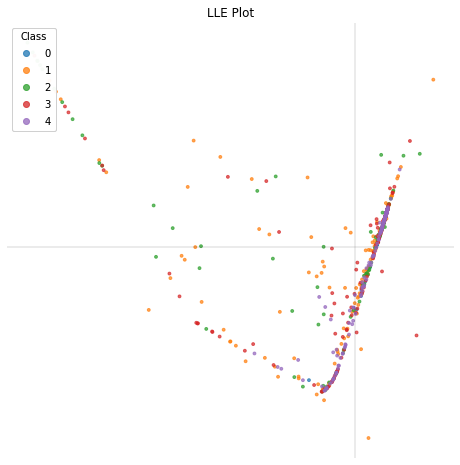

In [44]:
# set up an LLE object

def exp_lle(X, y, subsample=10):
    lle = sklearn.manifold.LocallyLinearEmbedding(n_components=2, eigen_solver='dense')
    lle_X = lle.fit_transform(X[::subsample, :])
    visualize(lle_X, y, subsample, "LLE Plot")
    
exp_lle(X, y)

# ISOMAP

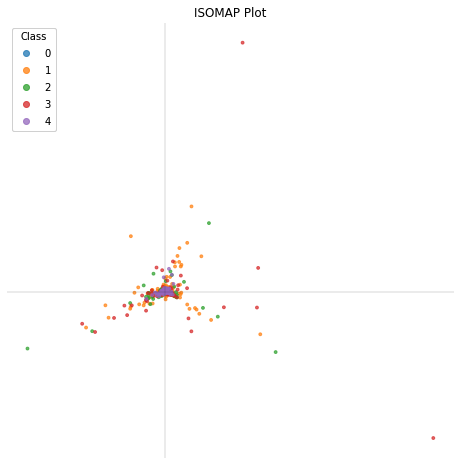

In [45]:

def exp_isomap(X, y, subsample=10):
    isomap = sklearn.manifold.Isomap(n_neighbors=10, n_components=2)
    iso_X = isomap.fit_transform(X[::subsample, :])
    visualize(iso_X, y, subsample, "ISOMAP Plot")

exp_isomap(X,y)

# UMAP

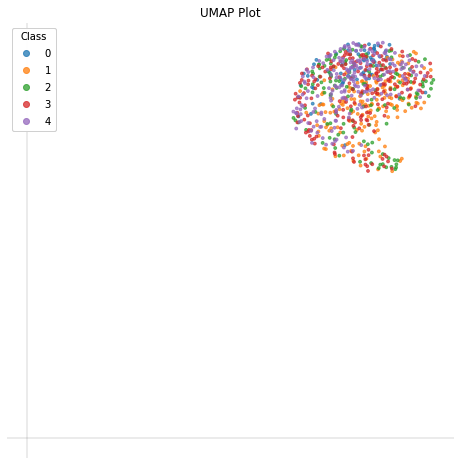

In [46]:
import sklearn.decomposition, sklearn.manifold


# create a UMAP object
def exp_umap(X, y, subsample=10):
    # fix bug in umap import where it throws import error after first run
    import umap.umap_ as umap
    
    umap  = umap.UMAP(min_dist=0.9,n_components=2, random_state=10)
    umap_X = umap.fit_transform(X[::subsample, :])
    visualize(umap_X, y, subsample, "UMAP Plot")

exp_umap(X,y)

# TSNE

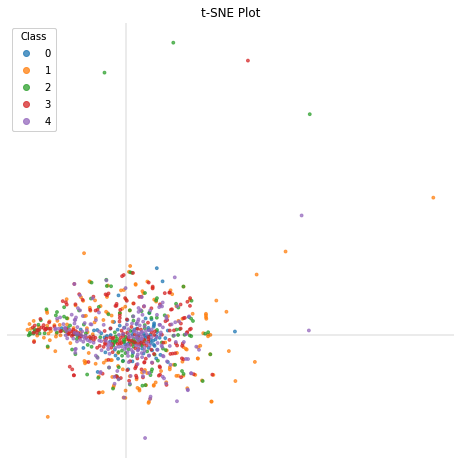

In [47]:

def exp_tsne(X, y, subsample=10):
    # create a tsne object
    tsne  = sklearn.manifold.TSNE(random_state=10)
    tsne_X = tsne.fit_transform(X[::subsample, :])
    visualize(tsne_X, y, subsample, "t-SNE Plot")
    
exp_tsne(X, y)

## Classifier
The code below creates a standard KNN classifier which predicts the output class based on the 7 nearest elements in feature vector space. 

In [48]:
# fit a classifier
classifier = audio_task.knn_fit(X, y)



### Visualising predictions 
You can preview your results with a separate (non-secret) test set which is provided. This will show you a visualisation of your classifier versus the ground truth. Each visualisation shows the true activity (below the axis) as coloured blocks and the predicted activity (from the classifier) as coloured blocks above the axis.

In the case of perfect classification, the blocks above and below the line will be exactly the same. In practice, there will always be significant noise.

Testing with data/challenge_test_0
Loading into 613 windows of length 256
Predicting...
Prediction accuracy 0.091
Confusion matrix
[[ 20   4 227 225  15]
 [ 15  32  62 179  40]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ 13   2  50  62  37]]

Testing with data/challenge_test_1
Loading into 950 windows of length 256
Predicting...
Prediction accuracy 0.255
Confusion matrix
[[ 23  13 117 221  84]
 [  0   0   0   0   0]
 [  7  30  79 163  26]
 [ 10  53 111 226  56]
 [ 14  19  63 148  60]]

Testing with data/challenge_test_2
Loading into 429 windows of length 256
Predicting...
Prediction accuracy 0.248
Confusion matrix
[[  0   0   0   0   0]
 [  9  16  23  54  13]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ 23   9 127 260 155]]

Testing with data/challenge_test_3
Loading into 886 windows of length 256
Predicting...
Prediction accuracy 0.274
Confusion matrix
[[ 28   2 157 273  14]
 [ 26  75  63 202 107]
 [  0   0   0   0   0]
 [ 14  51  89 286  33]
 [  0   0   0   0   0]]

Testing 

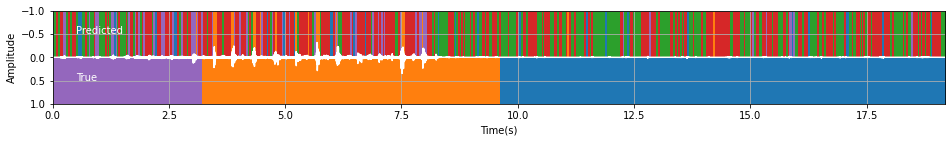

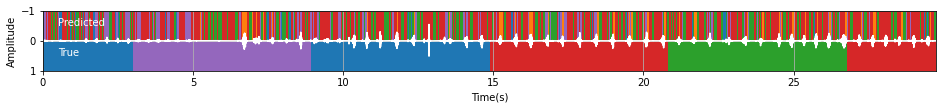

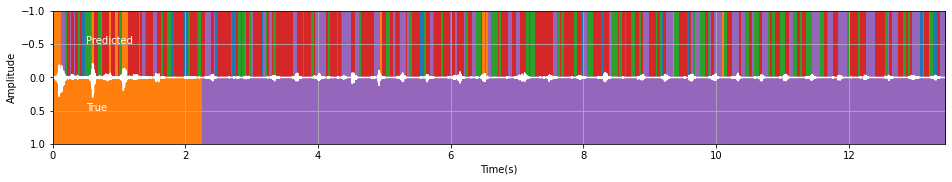

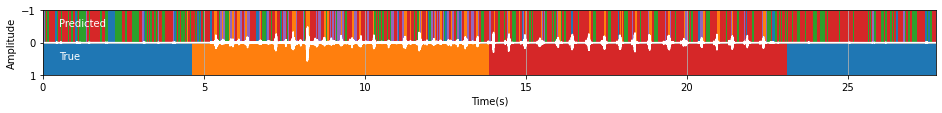

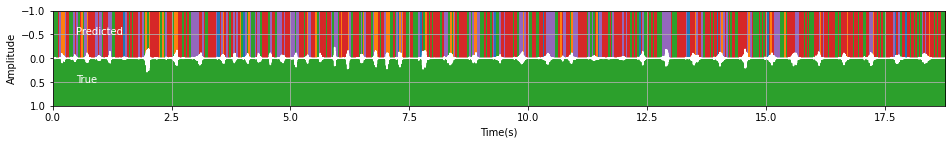

In [49]:
## Example usage -- show results for all of the test cases
for i in range(5):
    audio_task.plot_test(classifier, parameters, f"data/challenge_test_{i}")

### Final test function
There is a test function `challenge_evaluate_performance(classifier_fn)`. This gives you your total current score. You don't have access to the internals of this function. See below for how to use it.
The test takes some time to run; so you must be parsimonious with your calls to it.

In [50]:
## Shows how to evaluate your performance
audio_task.run_secret_test(classifier, parameters)

Loading into 1553 windows of length 256
Predicting...
Loading into 488 windows of length 256
Predicting...
Loading into 290 windows of length 256
Predicting...
Loading into 1388 windows of length 256
Predicting...
Loading into 62 windows of length 256
Predicting...
Loading into 560 windows of length 256
Predicting...
Loading into 394 windows of length 256
Predicting...
Loading into 1177 windows of length 256
Predicting...
*** Total score: 62.47 ***


# Experiment 1

71.28% accuracy

Loading into 699 windows of length 512
Loading into 1642 windows of length 512
Loading into 1411 windows of length 512
Loading into 1997 windows of length 512
Loading into 1937 windows of length 512
Using fft transform and a boxcar window.
X shape (7686, 512) y shape (7686,)


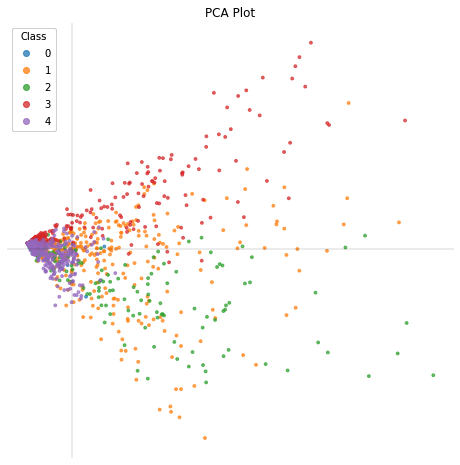

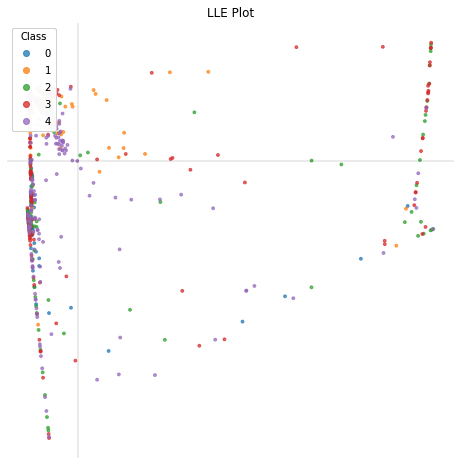

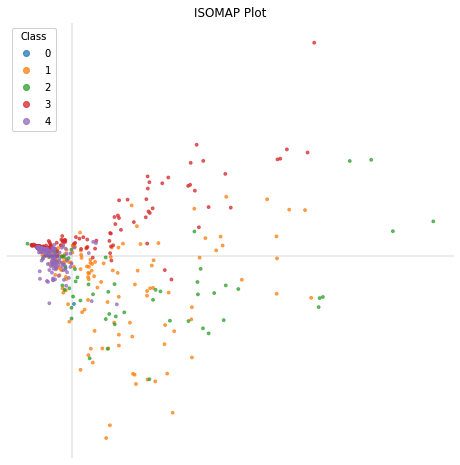

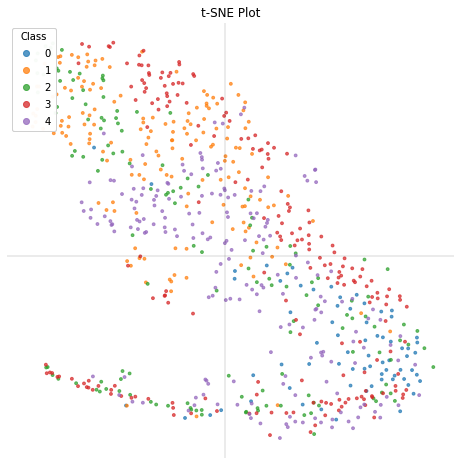

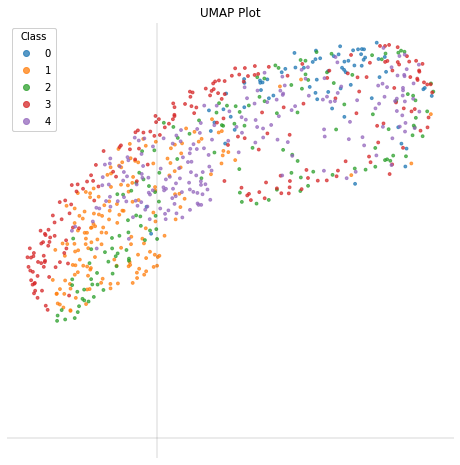

In [51]:
######### Experiment 1 PARAMETERS 71.28 ##################
# 1 sample = 1/4096 of a second

parameters = {
'size':512, 
'step':128, 
'decimate':1, 
'feature_range' :(0.0, 1.0),
'window_fn':"boxcar",
'feature_fn':"fft"
}
#####################################


X, y = audio_task.load_data(parameters)
print("X shape", X.shape, "y shape", y.shape)

# visualisations
exp_pca(X, y)
exp_lle(X, y)
exp_isomap(X, y)
exp_tsne(X, y)
exp_umap(X, y)



Testing with data/challenge_test_0
Loading into 611 windows of length 512
Predicting...
Prediction accuracy 0.372
Confusion matrix
[[219   0 130  74  68]
 [ 47  69 160  16  36]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  7   7  55  17  78]]

Testing with data/challenge_test_1
Loading into 948 windows of length 512
Predicting...
Prediction accuracy 0.248
Confusion matrix
[[ 26   4 125 211  92]
 [  0   0   0   0   0]
 [ 19  33  97 116  40]
 [  6  65 170 167  48]
 [ 32   2  54 128  88]]

Testing with data/challenge_test_2
Loading into 427 windows of length 512
Predicting...
Prediction accuracy 0.524
Confusion matrix
[[  0   0   0   0   0]
 [  2  19  49  17  28]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ 27   9 123  73 342]]

Testing with data/challenge_test_3
Loading into 884 windows of length 512
Predicting...
Prediction accuracy 0.415
Confusion matrix
[[168   0 180  43  83]
 [ 18 144 166  86  59]
 [  0   0   0   0   0]
 [ 19   5 146 278  25]
 [  0   0   0   0   0]]

Testing 

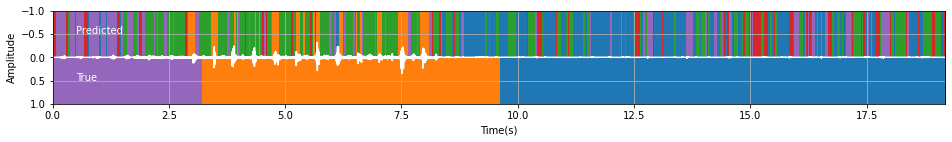

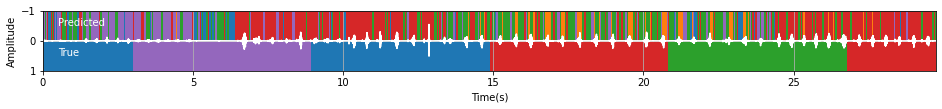

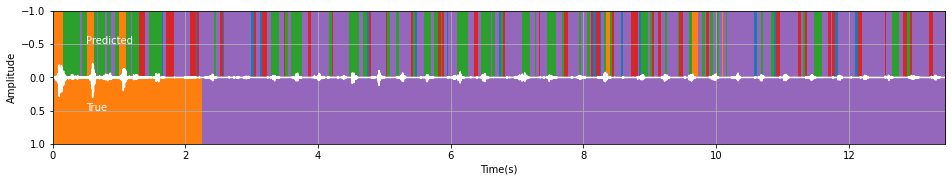

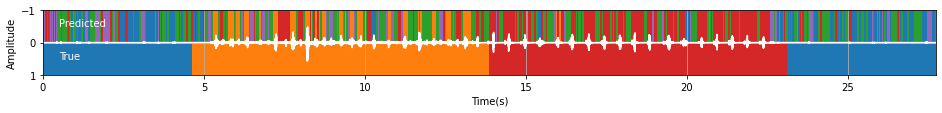

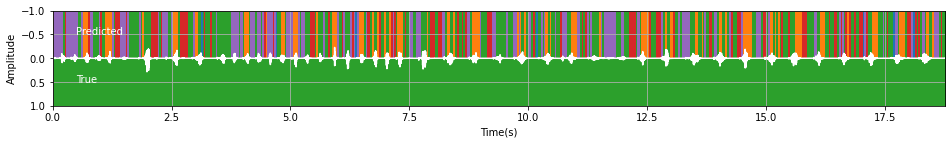

In [52]:
# fit a classifier
classifier = audio_task.knn_fit(X, y)

## Example usage -- show results for all of the test cases
for i in range(5):
    audio_task.plot_test(classifier, parameters, f"data/challenge_test_{i}")
    
## Shows how to evaluate your performance
audio_task.run_secret_test(classifier, parameters)

# Experiment 2
73.70% accuracy

In [53]:
######### EXPERIMENT 2 PARAMETERS 73.70 ##################
# You can change these values
# 1 sample = 1/4096 of a second

parameters = {
'size':512, # how long each window is, in samples
'step':64, # how many samples to move forward in each window
'decimate':1, # how much reduction of the feature vector to perform; integer = 1,2,3,4,5...
'feature_range' :(0.0, 1.0), # what slice of the feature vectors to take (0.0, 1.0)=whole vector
# must be between 0.0 and 1.0 for the start and end 
'window_fn':"blackmanharris", # one of window_fns (below)
'feature_fn':"fft" # one of feature_fns    
}
#####################################

# valid feature_fns: ['dct', 'fft', 'fft_phase', 'dct_phase', 'cepstrum', 'raw'])
# valid window_fns: ['hamming', 'hann', 'boxcar', 'blackmanharris']


Loading into 1397 windows of length 512
Loading into 3284 windows of length 512
Loading into 2821 windows of length 512
Loading into 3994 windows of length 512
Loading into 3873 windows of length 512
Using fft transform and a blackmanharris window.
X shape (15369, 512) y shape (15369,)


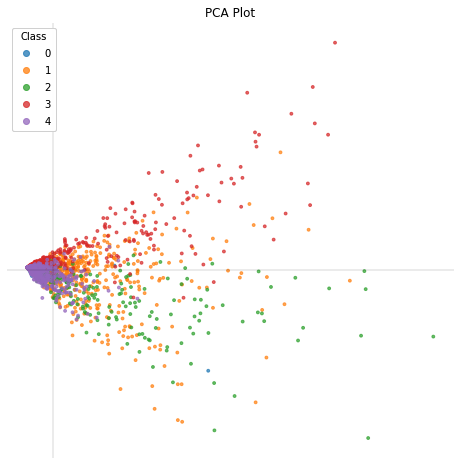

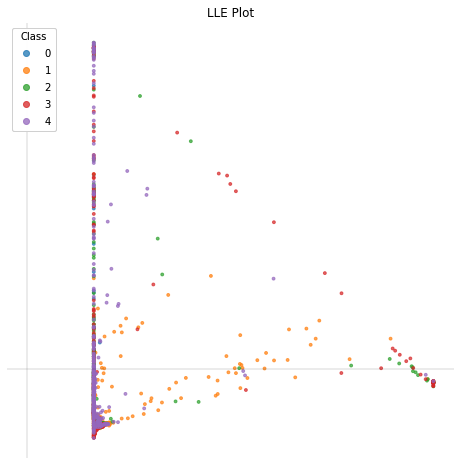

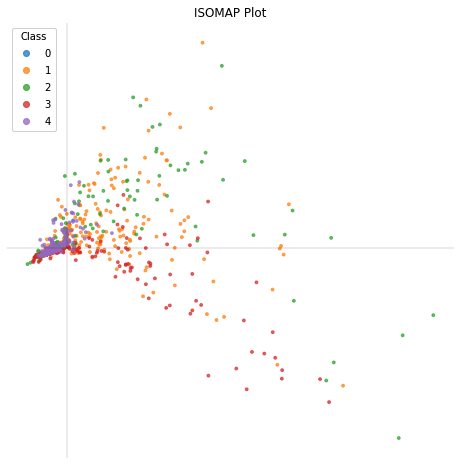

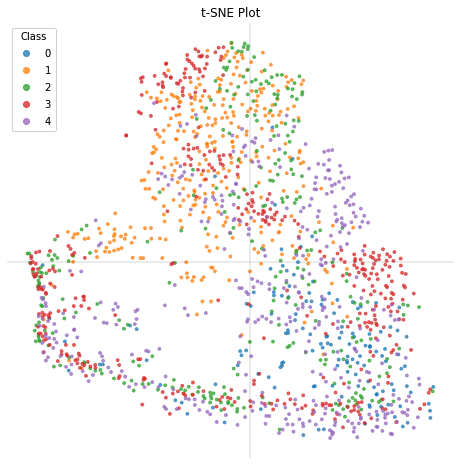

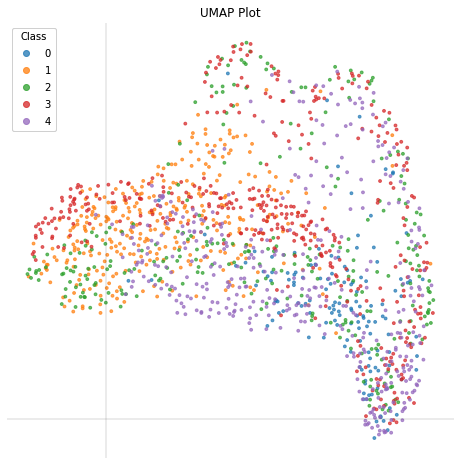

In [54]:
X, y = audio_task.load_data(parameters)
print("X shape", X.shape, "y shape", y.shape)

# visualisations

exp_pca(X, y)
exp_lle(X, y)
exp_isomap(X, y)
exp_tsne(X, y)
exp_umap(X, y)

Testing with data/challenge_test_0
Loading into 1221 windows of length 512
Predicting...
Prediction accuracy 0.305
Confusion matrix
[[149   0 136 119  87]
 [ 34  74 110  40  70]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  9   6  53  19  77]]

Testing with data/challenge_test_1
Loading into 1896 windows of length 512
Predicting...
Prediction accuracy 0.264
Confusion matrix
[[ 29   4 112 217  96]
 [  0   0   0   0   0]
 [  6  25  99 137  38]
 [  7  45 158 187  59]
 [ 30   2  63 122  87]]

Testing with data/challenge_test_2
Loading into 854 windows of length 512
Predicting...
Prediction accuracy 0.522
Confusion matrix
[[  0   0   0   0   0]
 [  8  28  23  15  41]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ 26   8 112  96 332]]

Testing with data/challenge_test_3
Loading into 1767 windows of length 512
Predicting...
Prediction accuracy 0.396
Confusion matrix
[[136   0 155  97  86]
 [  6 160 130  76 101]
 [  0   0   0   0   0]
 [ 13  17 157 267  19]
 [  0   0   0   0   0]]

Testi

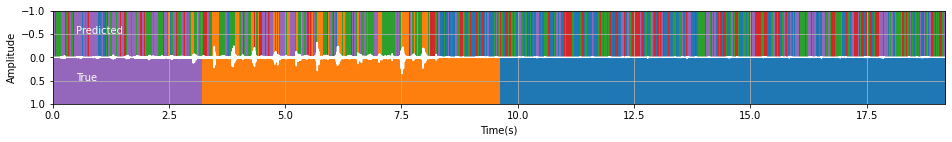

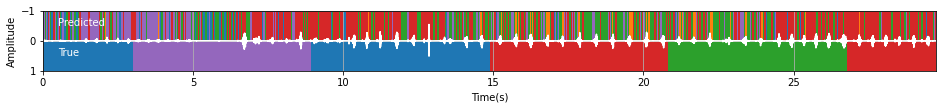

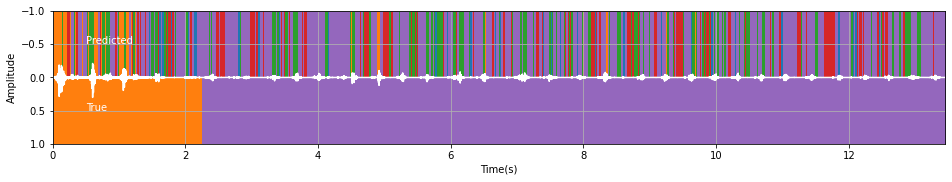

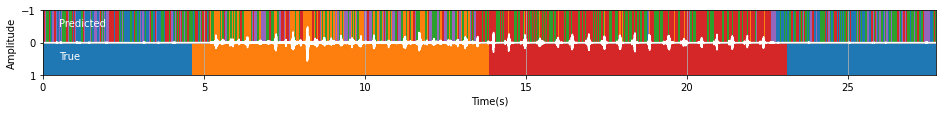

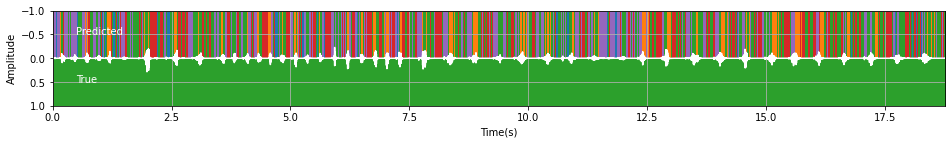

In [55]:
# fit a classifier
classifier = audio_task.knn_fit(X, y)

## Example usage -- show results for all of the test cases
for i in range(5):
    audio_task.plot_test(classifier, parameters, f"data/challenge_test_{i}")
    
## Shows how to evaluate your performance
audio_task.run_secret_test(classifier, parameters)

# Experiment 3

75.84% accuracy

In [56]:
######### EXPERIMENT 3 PARAMETERS 75.84 ##################
# You can change these values
# 1 sample = 1/4096 of a second

parameters = {
'size':512, # how long each window is, in samples
'step':64, # how many samples to move forward in each window
'decimate':4, # how much reduction of the feature vector to perform; integer = 1,2,3,4,5...
'feature_range' :(0.0, 1.0), # what slice of the feature vectors to take (0.0, 1.0)=whole vector
# must be between 0.0 and 1.0 for the start and end 
'window_fn':"blackmanharris", # one of window_fns (below)
'feature_fn':"fft" # one of feature_fns    
}
#####################################

# valid feature_fns: ['dct', 'fft', 'fft_phase', 'dct_phase', 'cepstrum', 'raw'])
# valid window_fns: ['hamming', 'hann', 'boxcar', 'blackmanharris']



Loading into 1397 windows of length 512
Loading into 3284 windows of length 512
Loading into 2821 windows of length 512
Loading into 3994 windows of length 512
Loading into 3873 windows of length 512
Using fft transform and a blackmanharris window.
X shape (15369, 128) y shape (15369,)


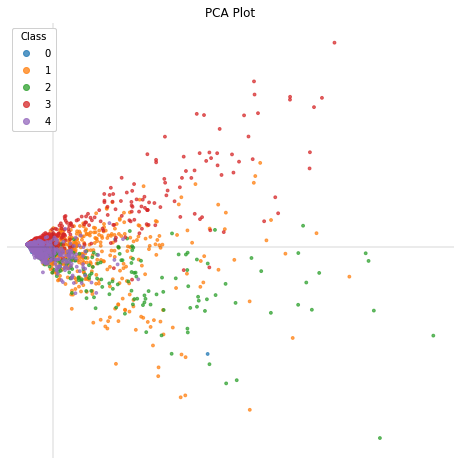

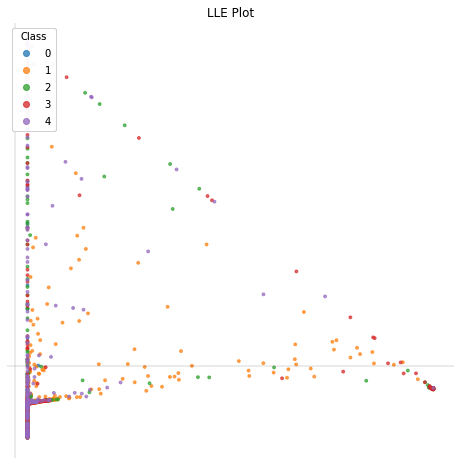

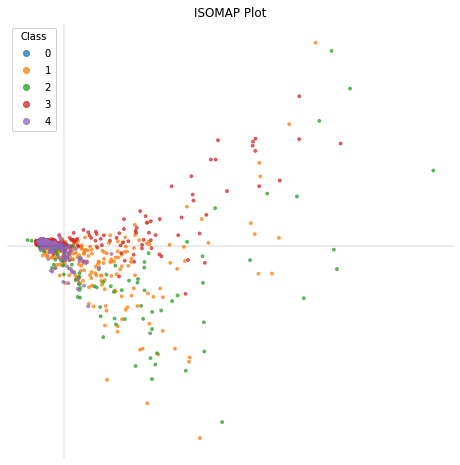

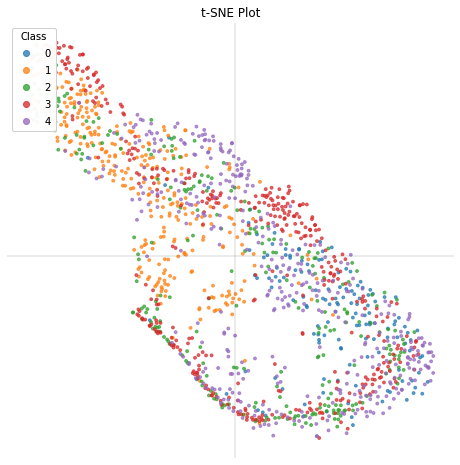

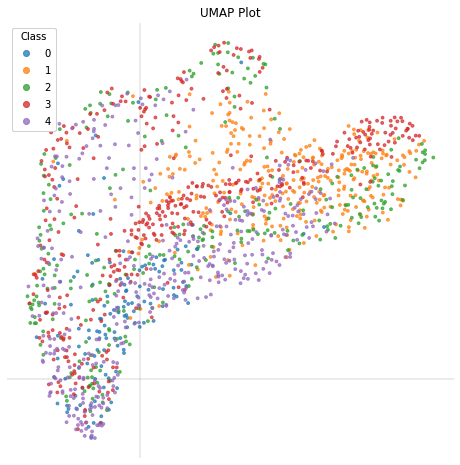

In [57]:

X, y = audio_task.load_data(parameters)
print("X shape", X.shape, "y shape", y.shape)

# visualisations

exp_pca(X, y)
exp_lle(X, y)
exp_isomap(X, y)
exp_tsne(X, y)
exp_umap(X, y)


Testing with data/challenge_test_0
Loading into 1221 windows of length 512
Predicting...
Prediction accuracy 0.373
Confusion matrix
[[143   1 114 117 116]
 [ 35 142  69  38  44]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  8  22  31  21  82]]

Testing with data/challenge_test_1
Loading into 1896 windows of length 512
Predicting...
Prediction accuracy 0.254
Confusion matrix
[[ 37  12 110 205  94]
 [  0   0   0   0   0]
 [ 14  40  78 119  54]
 [ 17  48 147 185  59]
 [ 37   4  53 123  87]]

Testing with data/challenge_test_2
Loading into 854 windows of length 512
Predicting...
Prediction accuracy 0.565
Confusion matrix
[[  0   0   0   0   0]
 [  7  41  14  13  40]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ 26  23  92  85 348]]

Testing with data/challenge_test_3
Loading into 1767 windows of length 512
Predicting...
Prediction accuracy 0.454
Confusion matrix
[[124   2 134 119  95]
 [ 11 260  81  50  71]
 [  0   0   0   0   0]
 [ 15  25 145 260  28]
 [  0   0   0   0   0]]

Testi

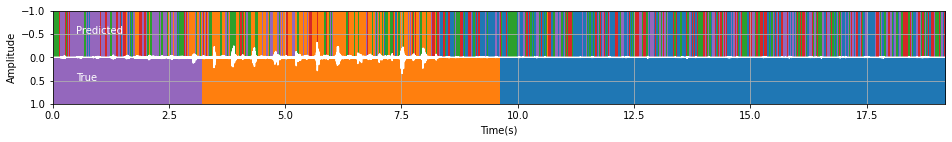

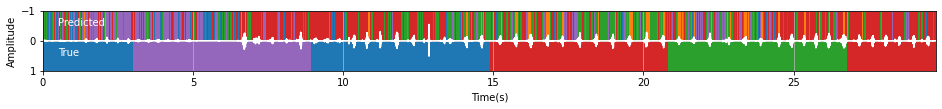

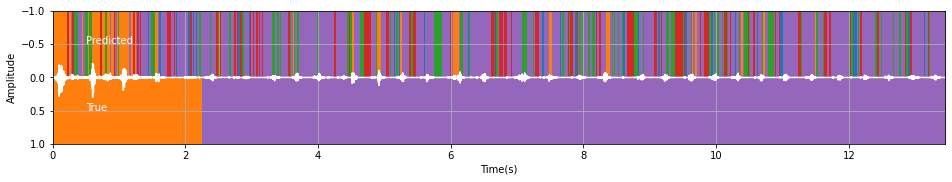

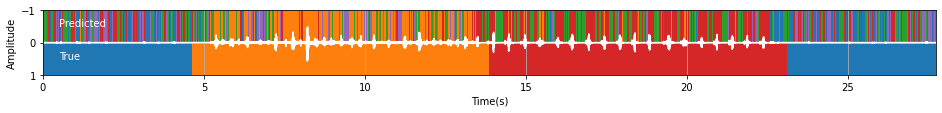

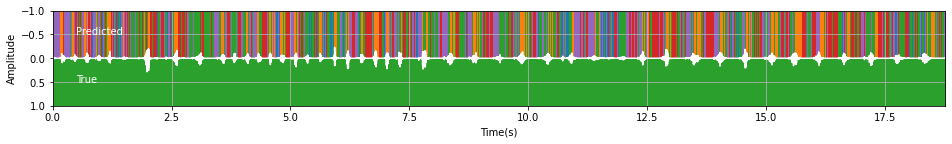

In [58]:
# fit a classifier
classifier = audio_task.knn_fit(X, y)

## Example usage -- show results for all of the test cases
for i in range(5):
    audio_task.plot_test(classifier, parameters, f"data/challenge_test_{i}")
    
## Shows how to evaluate your performance
audio_task.run_secret_test(classifier, parameters)

# Experiment 4

76.16% accuracy

Loading into 1397 windows of length 512
Loading into 3284 windows of length 512
Loading into 2821 windows of length 512
Loading into 3994 windows of length 512
Loading into 3873 windows of length 512
Using fft transform and a hamming window.
X shape (15369, 128) y shape (15369,)


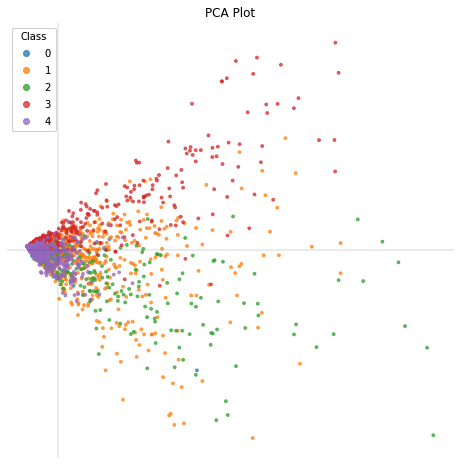

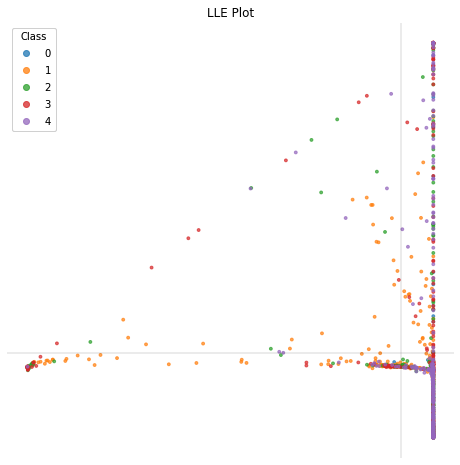

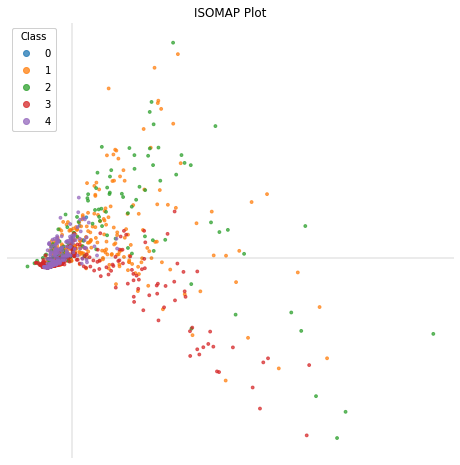

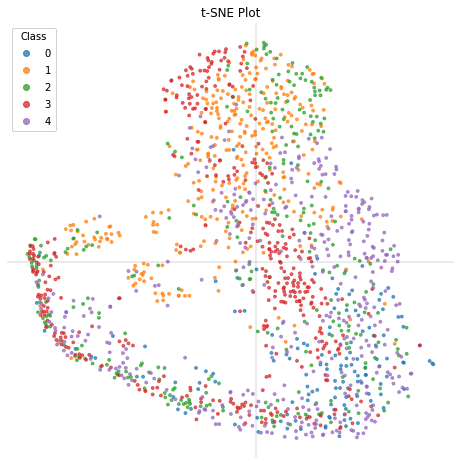

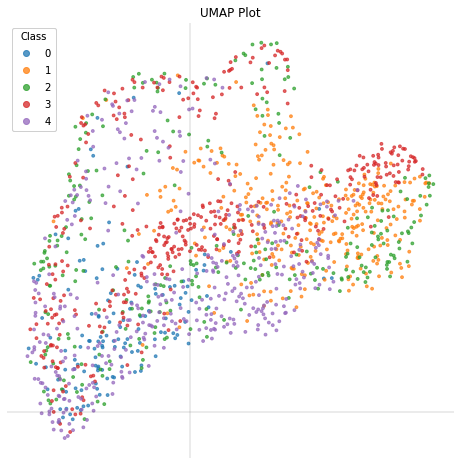

In [59]:
######### EXPERIMENT 4 PARAMETERS 76.16 ##################
# You can change these values
# 1 sample = 1/4096 of a second

parameters = {
'size':512, # how long each window is, in samples
'step':64, # how many samples to move forward in each window
'decimate':4, # how much reduction of the feature vector to perform; integer = 1,2,3,4,5...
'feature_range' :(0.0, 1.0), # what slice of the feature vectors to take (0.0, 1.0)=whole vector
# must be between 0.0 and 1.0 for the start and end 
'window_fn':"hamming", # one of window_fns (below)
'feature_fn':"fft" # one of feature_fns    
}
#####################################

# valid feature_fns: ['dct', 'fft', 'fft_phase', 'dct_phase', 'cepstrum', 'raw'])
# valid window_fns: ['hamming', 'hann', 'boxcar', 'blackmanharris']

# load audio
X, y = audio_task.load_data(parameters)
print("X shape", X.shape, "y shape", y.shape)

# visualisations

exp_pca(X, y)
exp_lle(X, y)
exp_isomap(X, y)
exp_tsne(X, y)
exp_umap(X, y)


Testing with data/challenge_test_0
Loading into 1221 windows of length 512
Predicting...
Prediction accuracy 0.394
Confusion matrix
[[181   0 118 114  78]
 [ 39 137  70  33  49]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ 14  17  43  21  69]]

Testing with data/challenge_test_1
Loading into 1896 windows of length 512
Predicting...
Prediction accuracy 0.261
Confusion matrix
[[ 37  18 101 204  98]
 [  0   0   0   0   0]
 [ 15  33  91 127  39]
 [ 19  59 152 175  51]
 [ 36   6  50 118  94]]

Testing with data/challenge_test_2
Loading into 854 windows of length 512
Predicting...
Prediction accuracy 0.595
Confusion matrix
[[  0   0   0   0   0]
 [  8  52  15  12  28]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ 42  19  80  75 358]]

Testing with data/challenge_test_3
Loading into 1767 windows of length 512
Predicting...
Prediction accuracy 0.467
Confusion matrix
[[142   0 155  78  99]
 [ 12 244  90  55  72]
 [  0   0   0   0   0]
 [ 17  25 131 277  23]
 [  0   0   0   0   0]]

Testi

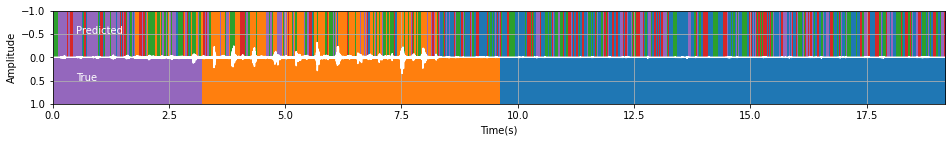

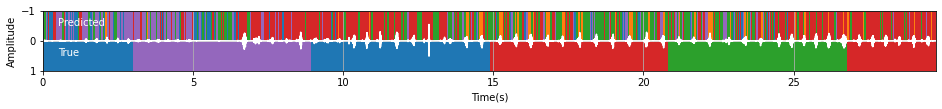

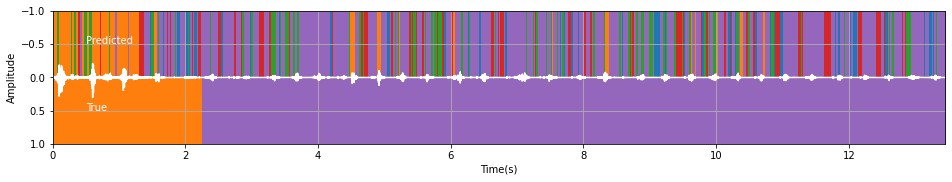

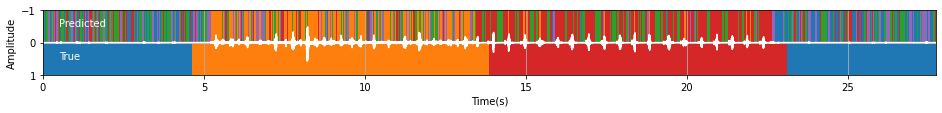

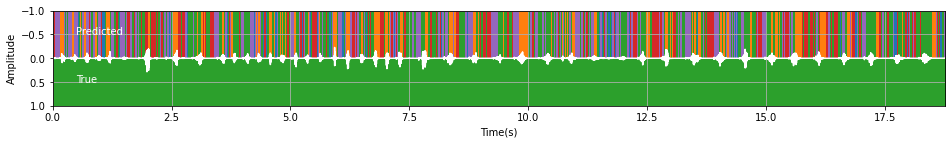

In [60]:
# fit a classifier
classifier = audio_task.knn_fit(X, y)

## Example usage -- show results for all of the test cases
for i in range(5):
    audio_task.plot_test(classifier, parameters, f"data/challenge_test_{i}")
    
## Shows how to evaluate your performance
audio_task.run_secret_test(classifier, parameters)

# Experiment 5

76.45% accuracy

In [61]:
######### EXPERIMENT 5 PARAMETERS 76.45  ##################
# You can change these values
# 1 sample = 1/4096 of a second

parameters = {
'size':512, # how long each window is, in samples
'step':64, # how many samples to move forward in each window
'decimate':4, # how much reduction of the feature vector to perform; integer = 1,2,3,4,5...
'feature_range' :(0.0, 1.0), # what slice of the feature vectors to take (0.0, 1.0)=whole vector
# must be between 0.0 and 1.0 for the start and end 
'window_fn':"boxcar", # one of window_fns (below)
'feature_fn':"fft" # one of feature_fns    
}
#####################################

# valid feature_fns: ['dct', 'fft', 'fft_phase', 'dct_phase', 'cepstrum', 'raw'])
# valid window_fns: ['hamming', 'hann', 'boxcar', 'blackmanharris']

Loading into 1397 windows of length 512
Loading into 3284 windows of length 512
Loading into 2821 windows of length 512
Loading into 3994 windows of length 512
Loading into 3873 windows of length 512
Using fft transform and a boxcar window.
X shape (15369, 128) y shape (15369,)


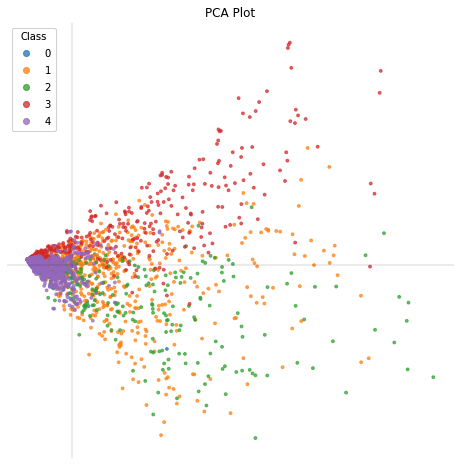

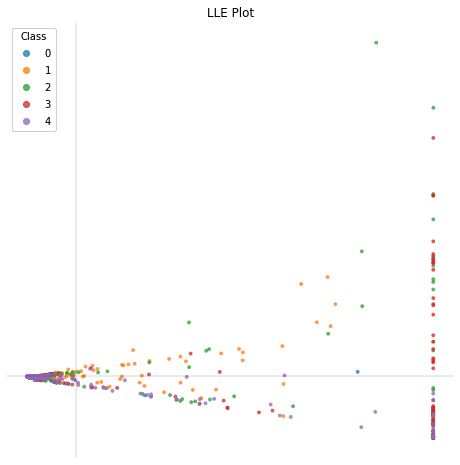

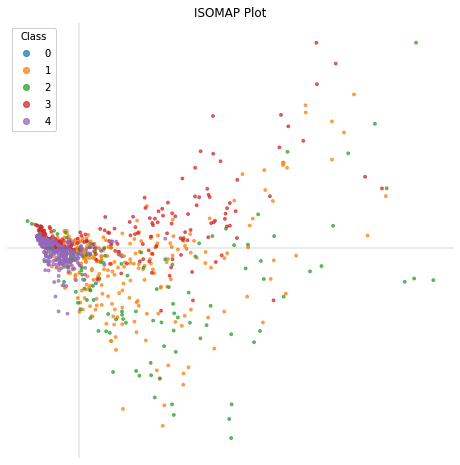

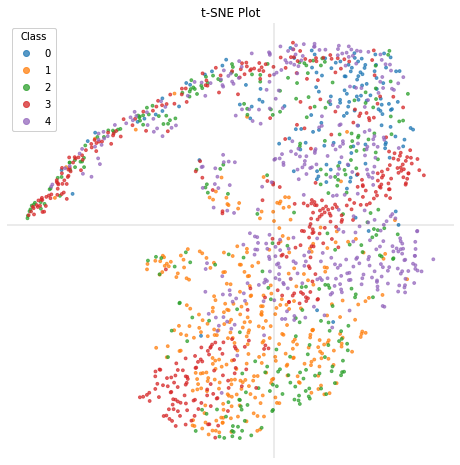

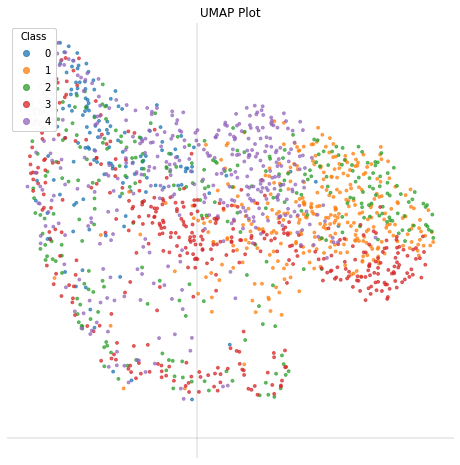

In [62]:
# load audio
X, y = audio_task.load_data(parameters)
print("X shape", X.shape, "y shape", y.shape)

# visualisations

exp_pca(X, y)
exp_lle(X, y)
exp_isomap(X, y)
exp_tsne(X, y)
exp_umap(X, y)


Testing with data/challenge_test_0
Loading into 1221 windows of length 512
Predicting...
Prediction accuracy 0.454
Confusion matrix
[[239   0 100  93  59]
 [ 46 138  81  23  40]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ 16  19  30  30  69]]

Testing with data/challenge_test_1
Loading into 1896 windows of length 512
Predicting...
Prediction accuracy 0.242
Confusion matrix
[[ 46  11 100 210  91]
 [  0   0   0   0   0]
 [ 17  51  63 125  49]
 [ 21  59 158 177  41]
 [ 46   4  49 123  82]]

Testing with data/challenge_test_2
Loading into 854 windows of length 512
Predicting...
Prediction accuracy 0.560
Confusion matrix
[[  0   0   0   0   0]
 [ 14  39  25  10  27]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ 37  22  88  80 347]]

Testing with data/challenge_test_3
Loading into 1767 windows of length 512
Predicting...
Prediction accuracy 0.513
Confusion matrix
[[205   0 144  74  51]
 [ 23 245  93  39  73]
 [  0   0   0   0   0]
 [ 27  33 117 279  17]
 [  0   0   0   0   0]]

Testi

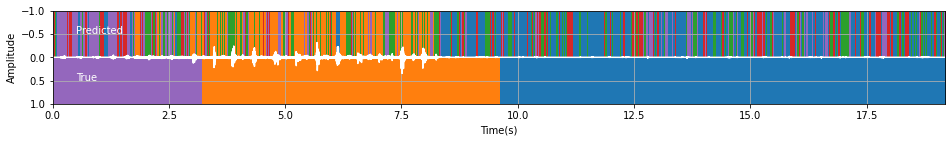

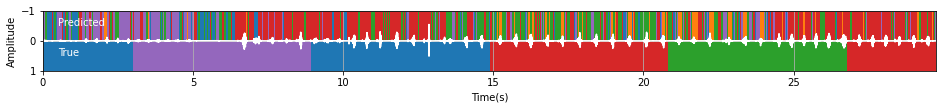

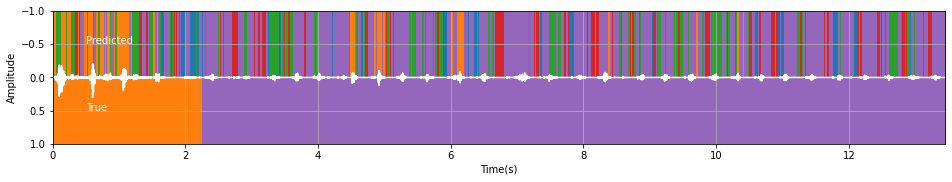

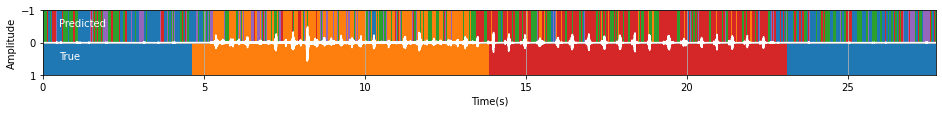

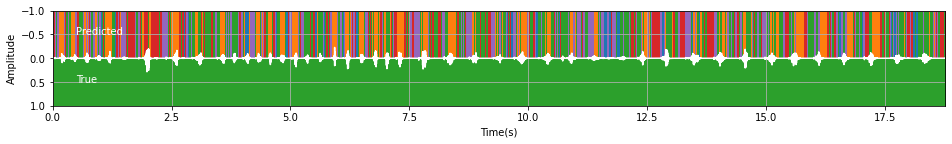

In [63]:
# fit a classifier
classifier = audio_task.knn_fit(X, y)

## Example usage -- show results for all of the test cases
for i in range(5):
    audio_task.plot_test(classifier, parameters, f"data/challenge_test_{i}")
    
## Shows how to evaluate your performance
audio_task.run_secret_test(classifier, parameters)

# Experiment 6

74.70% accuracy

In [64]:
######### EXPERIMENT 6 PARAMETERS 74.70 ##################
# You can change these values
# 1 sample = 1/4096 of a second

parameters = {
'size':512, # how long each window is, in samples
'step':64, # how many samples to move forward in each window
'decimate':4, # how much reduction of the feature vector to perform; integer = 1,2,3,4,5...
'feature_range' :(0.0, 1.0), # what slice of the feature vectors to take (0.0, 1.0)=whole vector
# must be between 0.0 and 1.0 for the start and end 
'window_fn':"blackmanharris", # one of window_fns (below)
'feature_fn':"dct" # one of feature_fns    
}
#####################################

# valid feature_fns: ['dct', 'fft', 'fft_phase', 'dct_phase', 'cepstrum', 'raw'])
# valid window_fns: ['hamming', 'hann', 'boxcar', 'blackmanharris']

Loading into 1397 windows of length 512
Loading into 3284 windows of length 512
Loading into 2821 windows of length 512
Loading into 3994 windows of length 512
Loading into 3873 windows of length 512
Using dct transform and a blackmanharris window.
X shape (15369, 128) y shape (15369,)


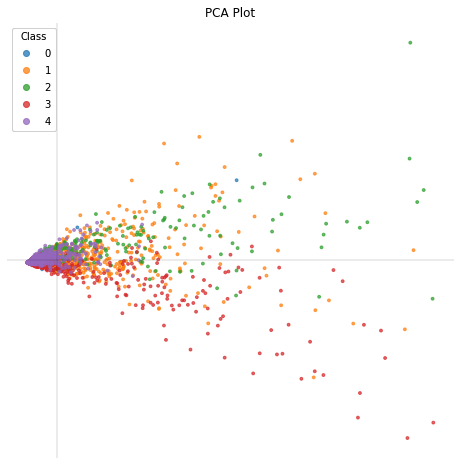

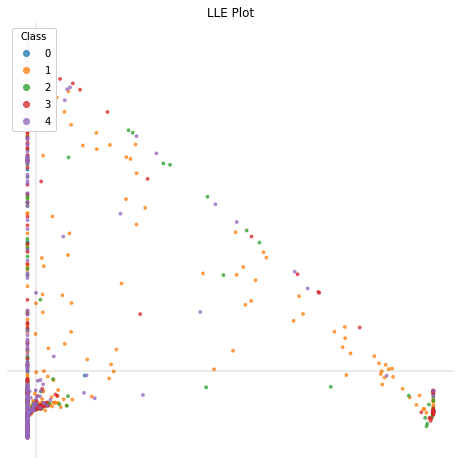

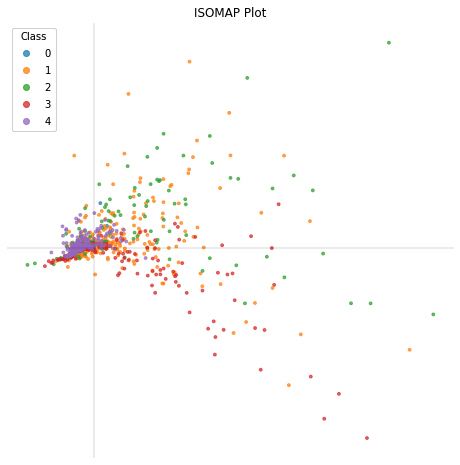

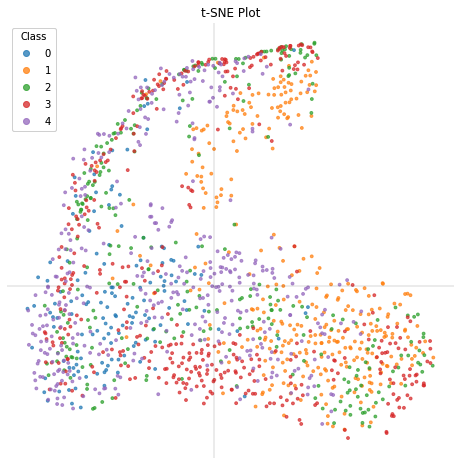

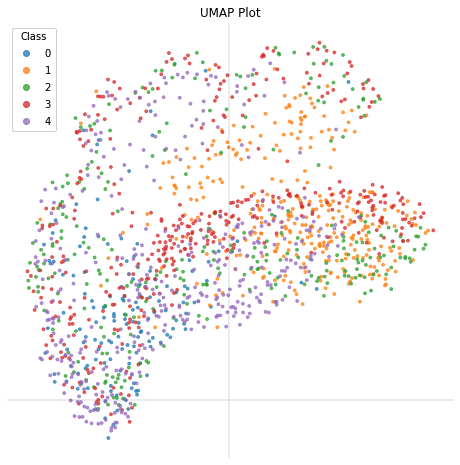

In [65]:
# load audio
X, y = audio_task.load_data(parameters)
print("X shape", X.shape, "y shape", y.shape)

# visualisations

exp_pca(X, y)
exp_lle(X, y)
exp_isomap(X, y)
exp_tsne(X, y)
exp_umap(X, y)


Testing with data/challenge_test_0
Loading into 1221 windows of length 512
Predicting...
Prediction accuracy 0.373
Confusion matrix
[[140   1 131 138  81]
 [ 42 146  35  64  41]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ 15  17  25  26  81]]

Testing with data/challenge_test_1
Loading into 1896 windows of length 512
Predicting...
Prediction accuracy 0.257
Confusion matrix
[[ 36  23  88 214  97]
 [  0   0   0   0   0]
 [  8  43  70 124  60]
 [ 11  66  99 185  95]
 [ 28  12  44 120 100]]

Testing with data/challenge_test_2
Loading into 854 windows of length 512
Predicting...
Prediction accuracy 0.522
Confusion matrix
[[  0   0   0   0   0]
 [  9  44   8  22  32]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ 37  35  61 125 316]]

Testing with data/challenge_test_3
Loading into 1767 windows of length 512
Predicting...
Prediction accuracy 0.445
Confusion matrix
[[103   0 119 155  97]
 [ 10 258  49  86  70]
 [  0   0   0   0   0]
 [ 18  40 109 271  35]
 [  0   0   0   0   0]]

Testi

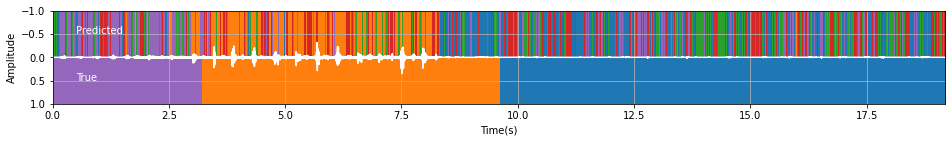

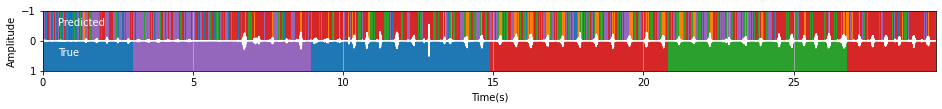

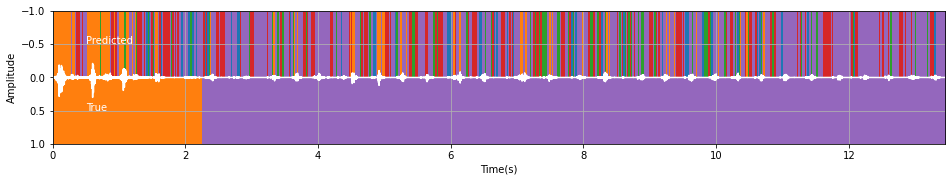

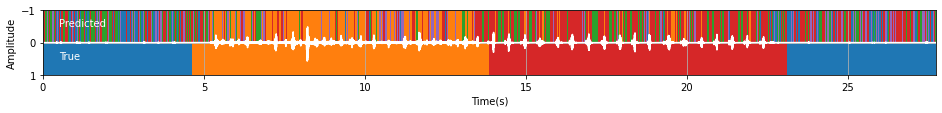

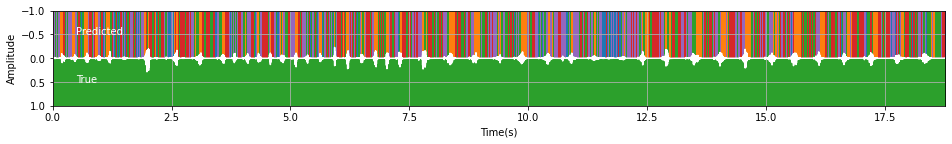

In [66]:
# fit a classifier
classifier = audio_task.knn_fit(X, y)

## Example usage -- show results for all of the test cases
for i in range(5):
    audio_task.plot_test(classifier, parameters, f"data/challenge_test_{i}")
    
## Shows how to evaluate your performance
audio_task.run_secret_test(classifier, parameters)

# Experiment 7

81.26% accuracy

In [67]:
######### EXPERIMENT 7 PARAMETERS 81.26   ##################
# You can change these values
# 1 sample = 1/4096 of a second

parameters = {
'size':2000, # how long each window is, in samples
'step':128, # how many samples to move forward in each window
'decimate':1, # how much reduction of the feature vector to perform; integer = 1,2,3,4,5...
'feature_range' :(0.0, 1.0), # what slice of the feature vectors to take (0.0, 1.0)=whole vector
# must be between 0.0 and 1.0 for the start and end 
'window_fn':"boxcar", # one of window_fns (below)
'feature_fn':"cepstrum" # one of feature_fns    
}
#####################################

# valid feature_fns: ['dct', 'fft', 'fft_phase', 'dct_phase', 'cepstrum', 'raw'])
# valid window_fns: ['hamming', 'hann', 'boxcar', 'blackmanharris']

Loading into 687 windows of length 2000
Loading into 1631 windows of length 2000
Loading into 1399 windows of length 2000
Loading into 1986 windows of length 2000
Loading into 1925 windows of length 2000
Using cepstrum transform and a boxcar window.
X shape (7628, 2000) y shape (7628,)


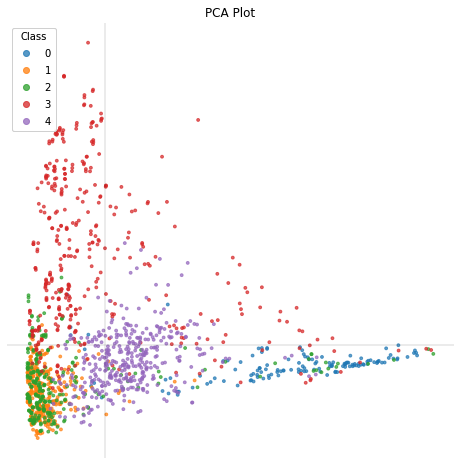

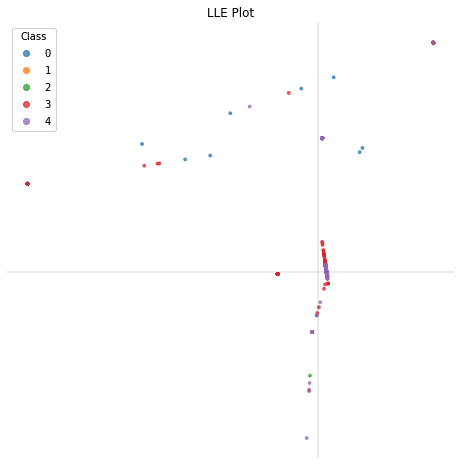

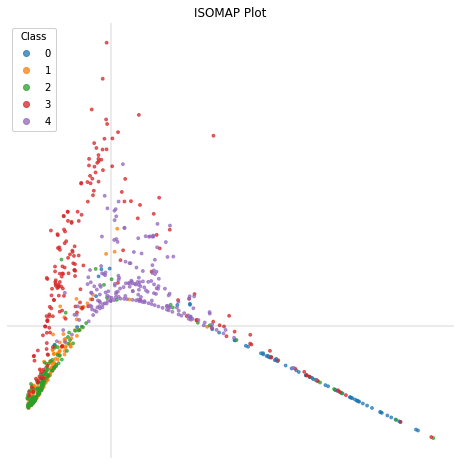

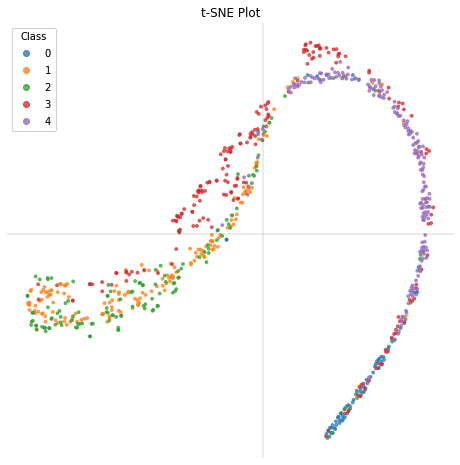

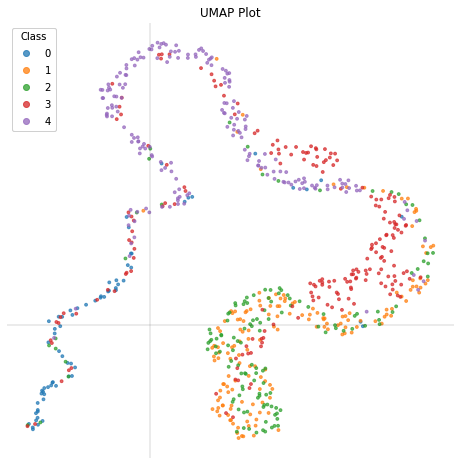

In [68]:
# load audio
X, y = audio_task.load_data(parameters)
print("X shape", X.shape, "y shape", y.shape)

# visualisations

exp_pca(X, y)
exp_lle(X, y)
exp_isomap(X, y)
exp_tsne(X, y)
exp_umap(X, y)


Testing with data/challenge_test_0
Loading into 599 windows of length 2000
Predicting...
Prediction accuracy 0.784
Confusion matrix
[[461   0  19  11   0]
 [ 53 180  42   8  45]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ 26   4   4   0 130]]

Testing with data/challenge_test_1
Loading into 936 windows of length 2000
Predicting...
Prediction accuracy 0.230
Confusion matrix
[[ 48  66   5 211 128]
 [  0   0   0   0   0]
 [  9  68  62 115  51]
 [  2 129 134 146  45]
 [ 74   0   2 134  94]]

Testing with data/challenge_test_2
Loading into 415 windows of length 2000
Predicting...
Prediction accuracy 0.856
Confusion matrix
[[  0   0   0   0]
 [ 15  54   8  38]
 [  0   0   0   0]
 [ 33   3   2 536]]

Testing with data/challenge_test_3
Loading into 872 windows of length 2000
Predicting...
Prediction accuracy 0.811
Confusion matrix
[[449   0  14  11   0]
 [ 16 350  35  27  45]
 [  0   0   0   0   0]
 [ 14  67  35 352   5]
 [  0   0   0   0   0]]

Testing with data/challenge_test_4
Loading 

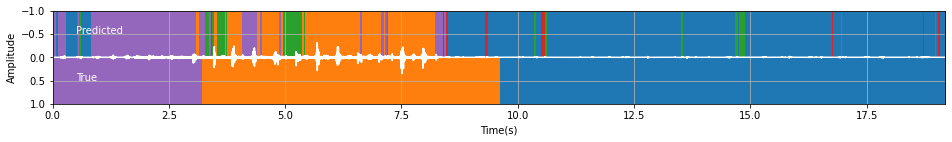

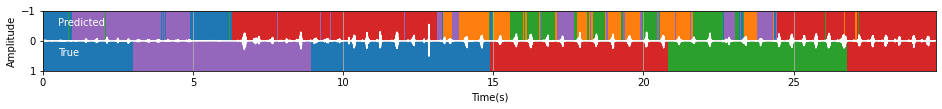

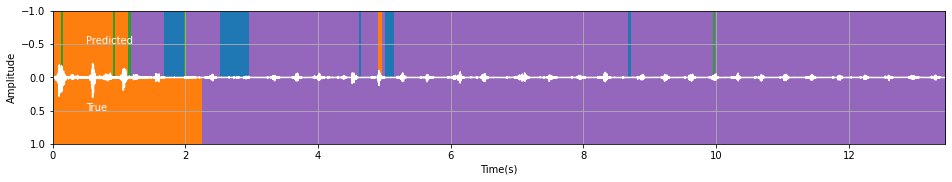

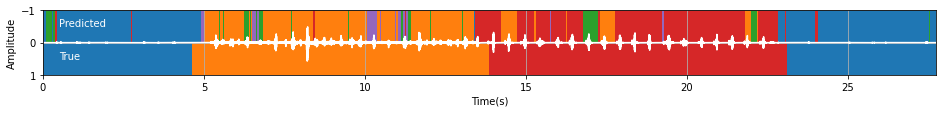

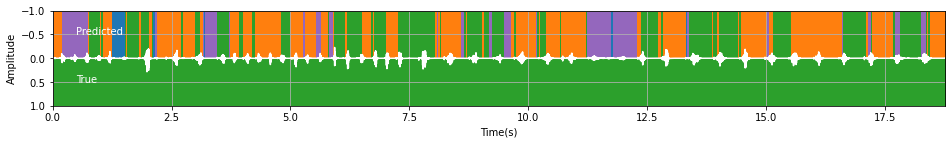

In [69]:
# fit a classifier
classifier = audio_task.knn_fit(X, y)

## Example usage -- show results for all of the test cases
for i in range(5):
    audio_task.plot_test(classifier, parameters, f"data/challenge_test_{i}")
    
## Shows how to evaluate your performance
audio_task.run_secret_test(classifier, parameters)

# Experiment 8

83.35% accuracy

In [70]:
######### EXPERIMENT 8 PARAMETERS 83.35   ##################
# You can change these values
# 1 sample = 1/4096 of a second

parameters = {
'size':2400, # how long each window is, in samples
'step':128, # how many samples to move forward in each window
'decimate':1, # how much reduction of the feature vector to perform; integer = 1,2,3,4,5...
'feature_range' :(0.0, 1.0), # what slice of the feature vectors to take (0.0, 1.0)=whole vector
# must be between 0.0 and 1.0 for the start and end 
'window_fn':"boxcar", # one of window_fns (below)
'feature_fn':"cepstrum" # one of feature_fns    
}
#####################################

# valid feature_fns: ['dct', 'fft', 'fft_phase', 'dct_phase', 'cepstrum', 'raw'])
# valid window_fns: ['hamming', 'hann', 'boxcar', 'blackmanharris']

Loading into 684 windows of length 2400
Loading into 1628 windows of length 2400
Loading into 1396 windows of length 2400
Loading into 1983 windows of length 2400
Loading into 1922 windows of length 2400
Using cepstrum transform and a boxcar window.
X shape (7613, 2400) y shape (7613,)


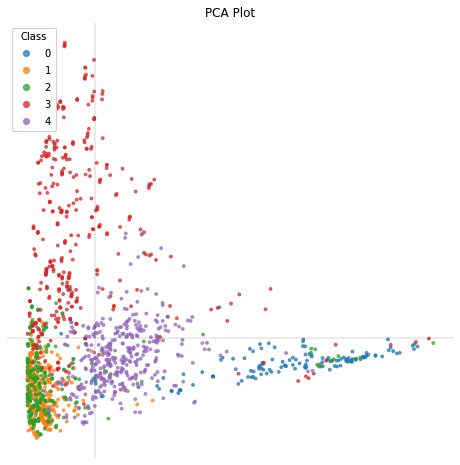

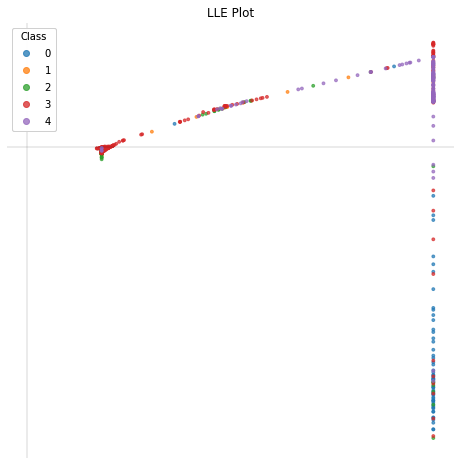

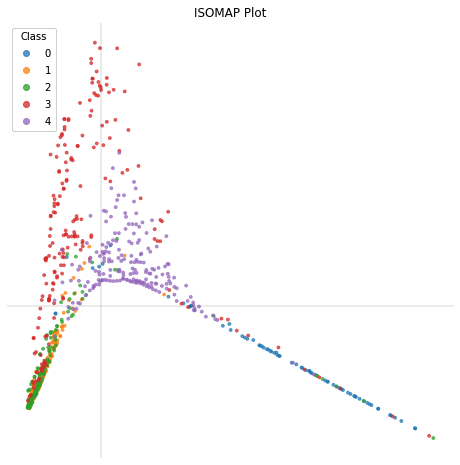

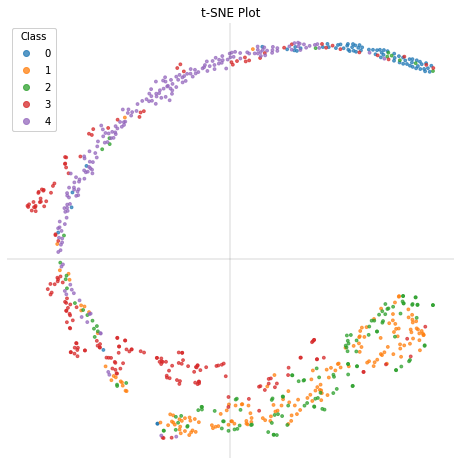

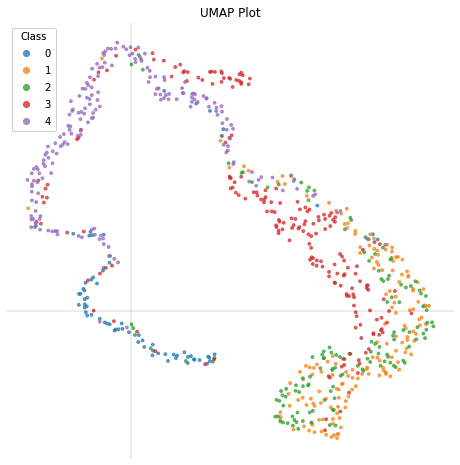

In [71]:
# load audio
X, y = audio_task.load_data(parameters)
print("X shape", X.shape, "y shape", y.shape)

# visualisations

exp_pca(X, y)
exp_lle(X, y)
exp_isomap(X, y)
exp_tsne(X, y)
exp_umap(X, y)


Testing with data/challenge_test_0
Loading into 596 windows of length 2400
Predicting...
Prediction accuracy 0.798
Confusion matrix
[[473   0  13   0   5]
 [ 53 188  52   8  27]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ 24  14   3   0 123]]

Testing with data/challenge_test_1
Loading into 933 windows of length 2400
Predicting...
Prediction accuracy 0.219
Confusion matrix
[[ 43  73   6 208 128]
 [  0   0   0   0   0]
 [  2  74  48 110  71]
 [  0 132 150 151  23]
 [ 77   0   0 135  92]]

Testing with data/challenge_test_2
Loading into 412 windows of length 2400
Predicting...
Prediction accuracy 0.890
Confusion matrix
[[  0   0   0   0]
 [ 10  58   2  45]
 [  0   0   0   0]
 [ 17   0   2 555]]

Testing with data/challenge_test_3
Loading into 869 windows of length 2400
Predicting...
Prediction accuracy 0.858
Confusion matrix
[[453   0  21   0   0]
 [ 11 368  40  24  30]
 [  0   0   0   0   0]
 [ 11  37  28 397   0]
 [  0   0   0   0   0]]

Testing with data/challenge_test_4
Loading 

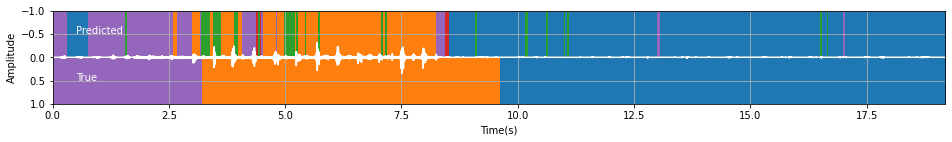

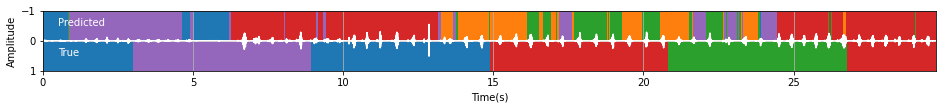

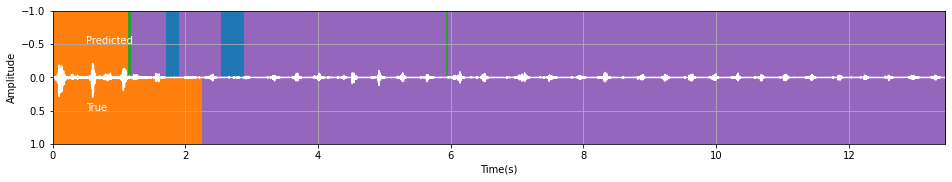

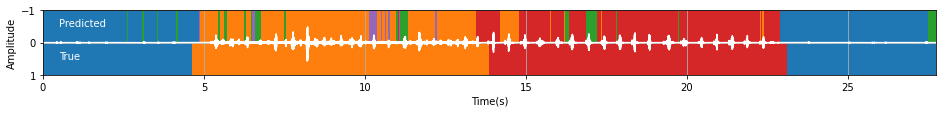

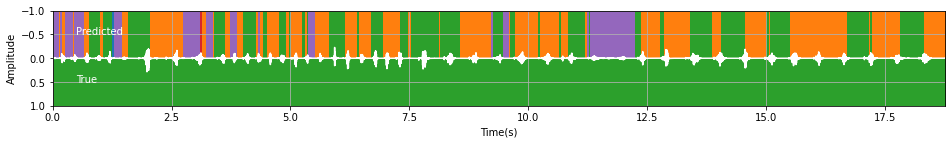

In [72]:
# fit a classifier
classifier = audio_task.knn_fit(X, y)

## Example usage -- show results for all of the test cases
for i in range(5):
    audio_task.plot_test(classifier, parameters, f"data/challenge_test_{i}")
    
## Shows how to evaluate your performance
audio_task.run_secret_test(classifier, parameters)

# Experiment 9

85.13% accuracy

In [73]:
### EXPT 9###
######### PARAMETERS ##################
# You can change these values
# 1 sample = 1/4096 of a second
# 85.13
parameters = {
'size':6339, # how long each window is, in samples
'step':50, # how many samples to move forward in each window
'decimate':20, # how much reduction of the feature vector to perform; integer = 1,2,3,4,5...
'feature_range' :(0.0, 1.0), # what slice of the feature vectors to take (0.0, 1.0)=whole vector
# must be between 0.0 and 1.0 for the start and end 
'window_fn':"boxcar", # one of window_fns (below)
'feature_fn':"fft" # one of feature_fns    
}
#####################################

# valid feature_fns: ['dct', 'fft', 'fft_phase', 'dct_phase', 'cepstrum', 'raw'])
# valid window_fns: ['hamming', 'hann', 'boxcar', 'blackmanharris']

Loading into 1671 windows of length 6339
Loading into 4087 windows of length 6339
Loading into 3495 windows of length 6339
Loading into 4996 windows of length 6339
Loading into 4841 windows of length 6339
Using fft transform and a boxcar window.
X shape (19090, 317) y shape (19090,)


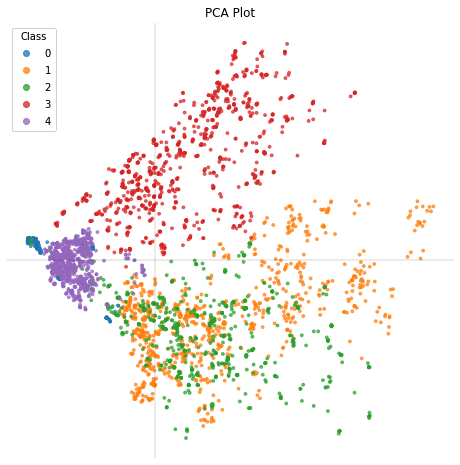

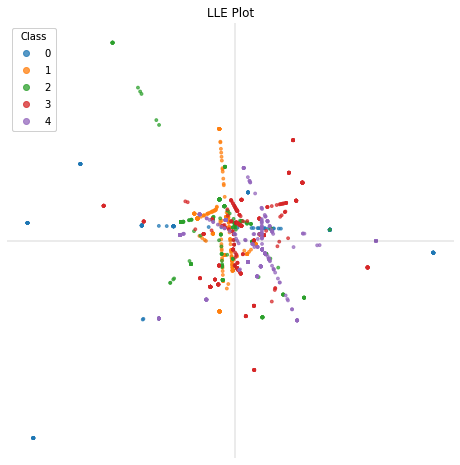

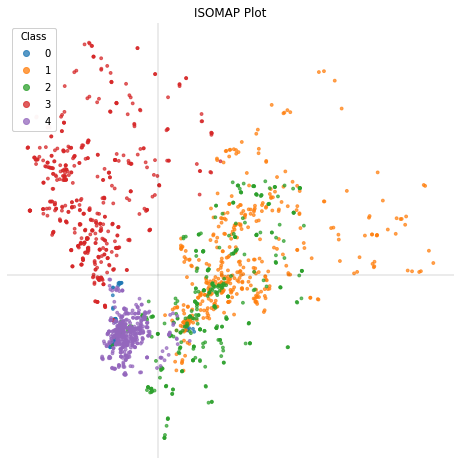

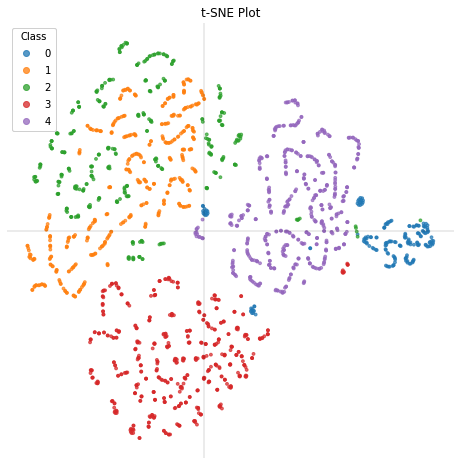

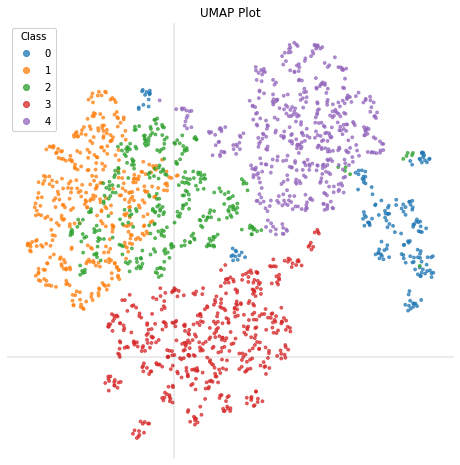

In [74]:
# load audio
X, y = audio_task.load_data(parameters)
print("X shape", X.shape, "y shape", y.shape)

# visualisations

exp_pca(X, y)
exp_lle(X, y)
exp_isomap(X, y)
exp_tsne(X, y)
exp_umap(X, y)


Testing with data/challenge_test_0
Loading into 1446 windows of length 6339
Predicting...
Prediction accuracy 0.682
Confusion matrix
[[491   0   0   0   0]
 [106  84  49  62  27]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [ 53   0  16   0  95]]

Testing with data/challenge_test_1
Loading into 2310 windows of length 6339
Predicting...
Prediction accuracy 0.148
Confusion matrix
[[ 13   2  64 239 140]
 [  0   0   0   0   0]
 [  2 133   2 130  38]
 [  0 273  30 153   0]
 [ 67   0   0 179  58]]

Testing with data/challenge_test_2
Loading into 976 windows of length 6339
Predicting...
Prediction accuracy 0.827
Confusion matrix
[[  0   0   0   0]
 [ 17  13   7  78]
 [  0   0   0   0]
 [  0   0  17 557]]

Testing with data/challenge_test_3
Loading into 2145 windows of length 6339
Predicting...
Prediction accuracy 0.804
Confusion matrix
[[412   0  22  30  10]
 [101 258  80  33   1]
 [  0   0   0   0   0]
 [  0   1   0 472   0]
 [  0   0   0   0   0]]

Testing with data/challenge_test_4
Loadi

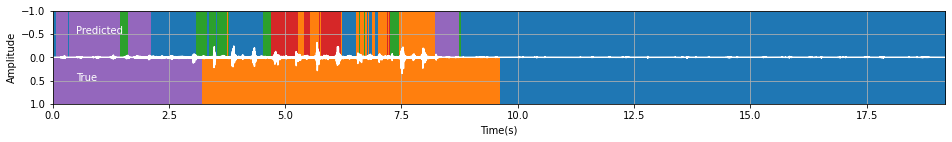

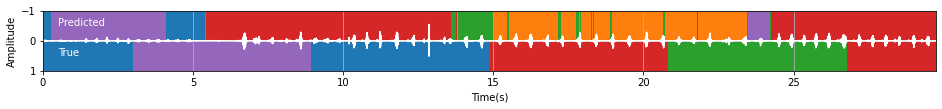

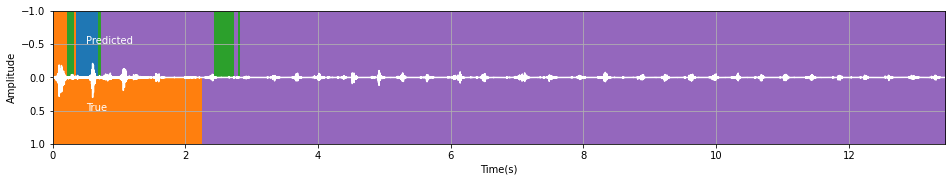

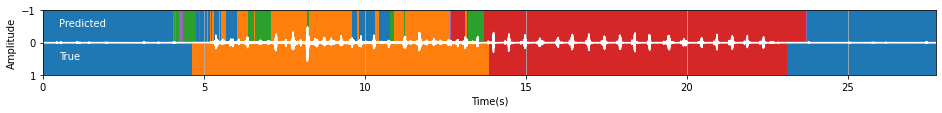

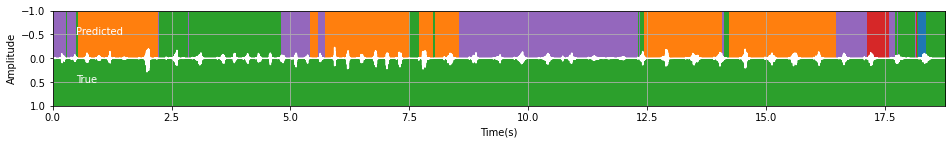

In [75]:
# fit a classifier
classifier = audio_task.knn_fit(X, y)

## Example usage -- show results for all of the test cases
for i in range(5):
    audio_task.plot_test(classifier, parameters, f"data/challenge_test_{i}")
    
## Shows how to evaluate your performance
audio_task.run_secret_test(classifier, parameters)

# Experiment 10

87.25% accuracy

In [76]:
######### EXPERIMENT 10 PARAMETERS 87.25 ##################
# You can change these values
# 1 sample = 1/4096 of a second

parameters = {
'size':4096, # how long each window is, in samples
'step':32, # how many samples to move forward in each window
'decimate':2, # how much reduction of the feature vector to perform; integer = 1,2,3,4,5...
'feature_range' :(0.0, 1.0), # what slice of the feature vectors to take (0.0, 1.0)=whole vector
# must be between 0.0 and 1.0 for the start and end 
'window_fn':"boxcar", # one of window_fns (below)
'feature_fn':"cepstrum" # one of feature_fns
}
#####################################

# valid feature_fns: ['dct', 'fft', 'fft_phase', 'dct_phase', 'cepstrum', 'raw'])
# valid window_fns: ['hamming', 'hann', 'boxcar', 'blackmanharris']

Loading into 2681 windows of length 4096
Loading into 6456 windows of length 4096
Loading into 5530 windows of length 4096
Loading into 7876 windows of length 4096
Loading into 7633 windows of length 4096
Using cepstrum transform and a boxcar window.
X shape (30176, 2048) y shape (30176,)


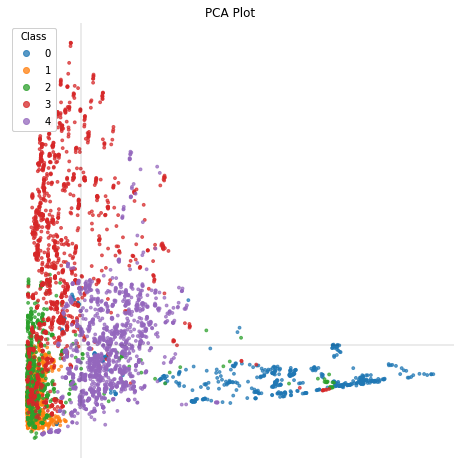

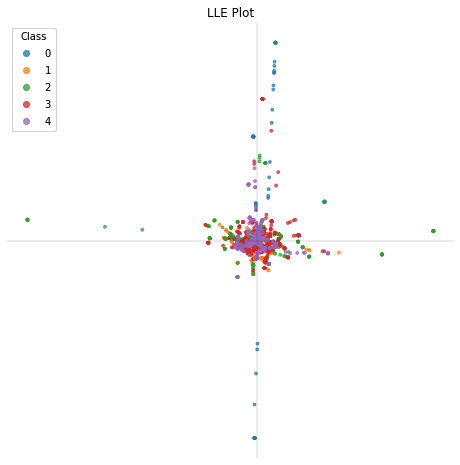

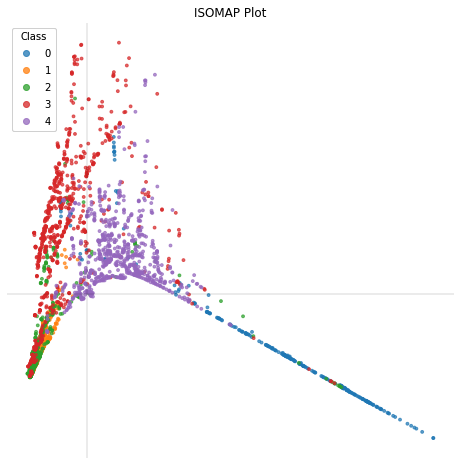

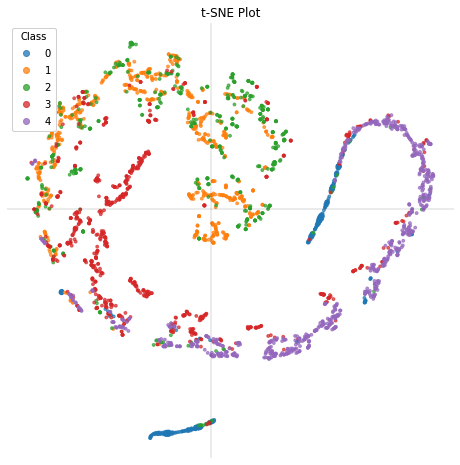

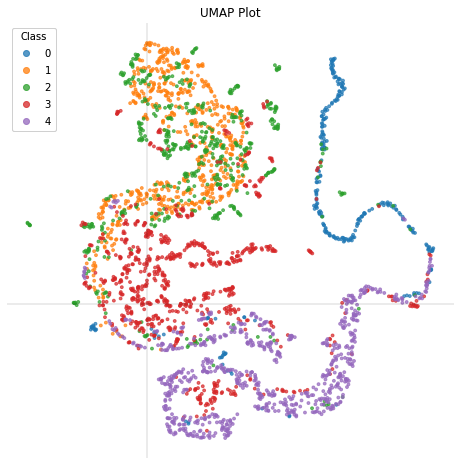

In [77]:
# load audio
X, y = audio_task.load_data(parameters)
print("X shape", X.shape, "y shape", y.shape)

# visualisations

exp_pca(X, y)
exp_lle(X, y)
exp_isomap(X, y)
exp_tsne(X, y)
exp_umap(X, y)


Testing with data/challenge_test_0
Loading into 2329 windows of length 4096
Predicting...
Prediction accuracy 0.640
Confusion matrix
[[412   0  64  15   0]
 [ 51 119 125  12  21]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  6  15  30  15  98]]

Testing with data/challenge_test_1
Loading into 3679 windows of length 4096
Predicting...
Prediction accuracy 0.244
Confusion matrix
[[ 25  29  33 206 165]
 [  0   0   0   0   0]
 [  0  93 103  96  13]
 [  0 122 177 156   1]
 [ 62   0   3 152  87]]

Testing with data/challenge_test_2
Loading into 1595 windows of length 4096
Predicting...
Prediction accuracy 0.868
Confusion matrix
[[  0   0   0   0   0]
 [  0  44  16   0  55]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  2   0   4  14 554]]

Testing with data/challenge_test_3
Loading into 3421 windows of length 4096
Predicting...
Prediction accuracy 0.861
Confusion matrix
[[453   1   8  10   2]
 [  0 371  79  23   0]
 [  0   0   0   0   0]
 [  0   5  70 398   0]
 [  0   0   0   0   0]]



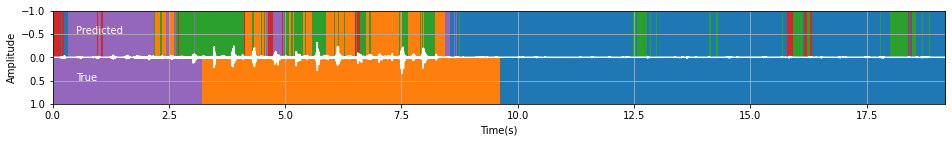

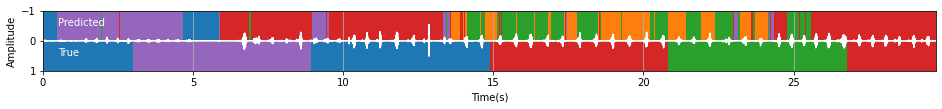

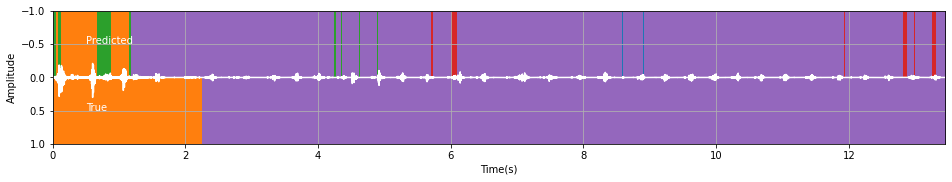

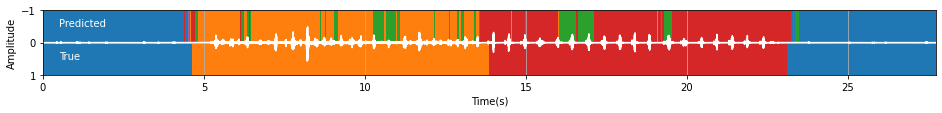

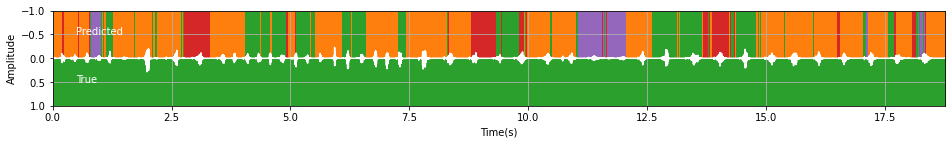

In [78]:
# fit a classifier
classifier = audio_task.knn_fit(X, y)

## Example usage -- show results for all of the test cases
for i in range(5):
    audio_task.plot_test(classifier, parameters, f"data/challenge_test_{i}")
    
## Shows how to evaluate your performance
audio_task.run_secret_test(classifier, parameters)